In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pickle
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip

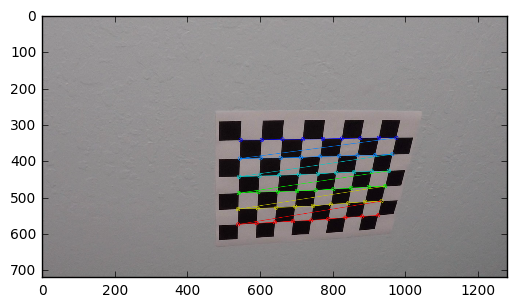

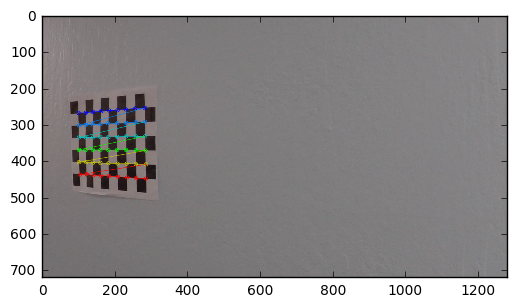

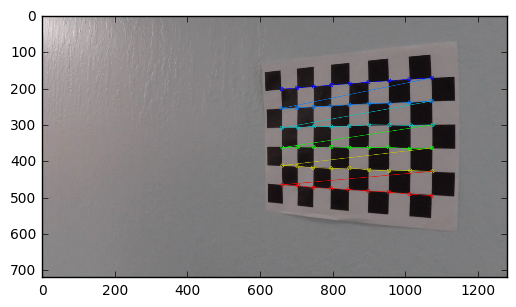

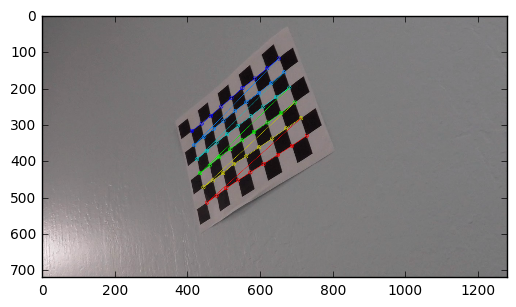

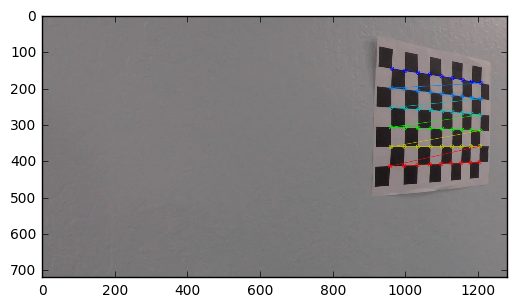

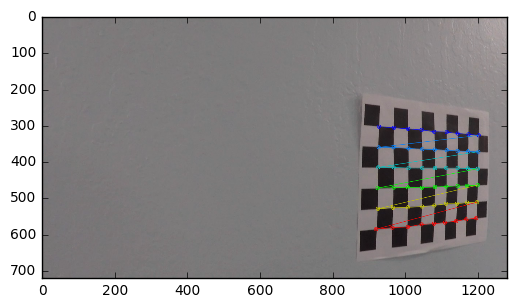

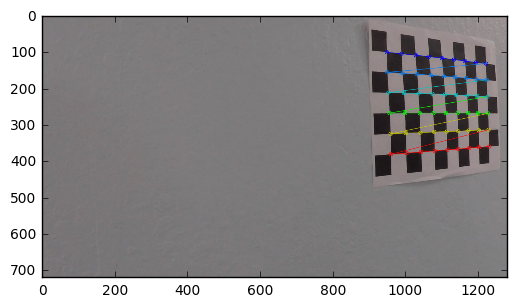

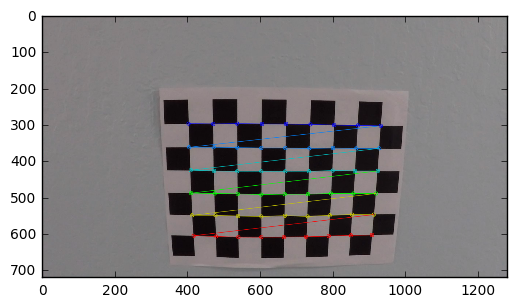

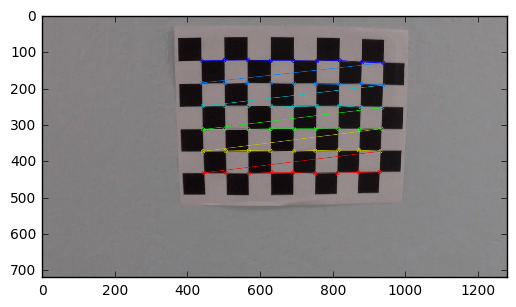

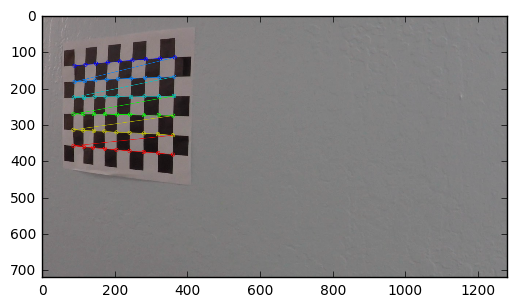

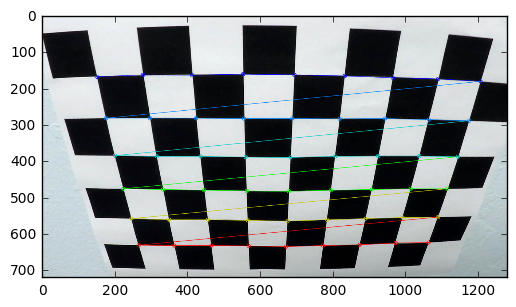

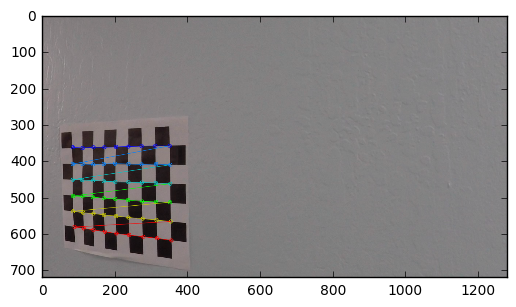

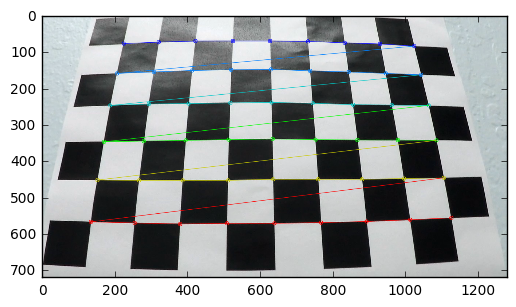

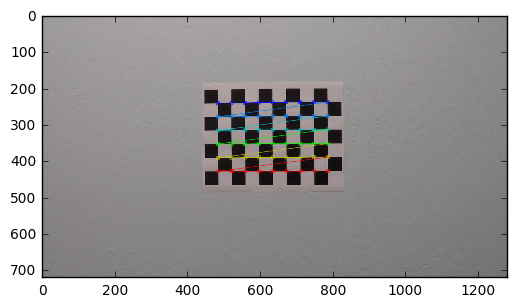

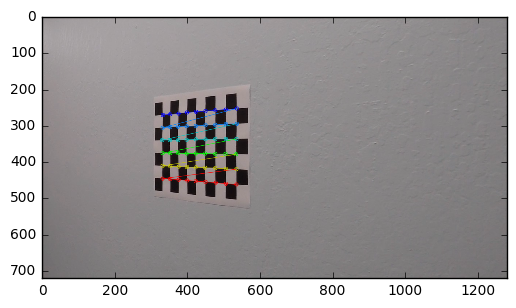

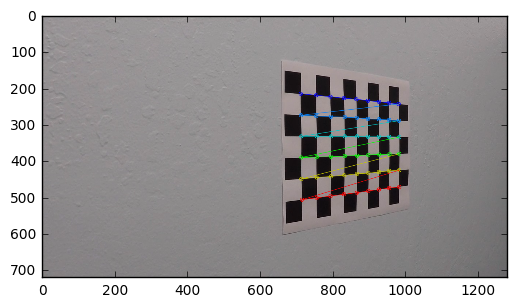

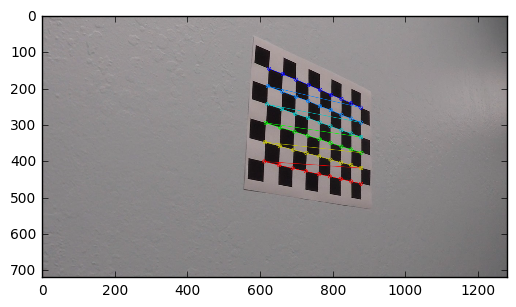

Calibration Saved


In [179]:
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(nx,ny,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        plt.imshow(img)
        plt.show()
        
    
def save_calibration(objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    calib = [mtx, dist]
    pickle.dump(calib, open("calibration.pkl", "wb"))

def load_calibration():
    calib = pickle.load(open("calibration.pkl", "rb"))
    return calib[0], calib[1]


save_calibration(objpoints, imgpoints)
print("Calibration Saved")

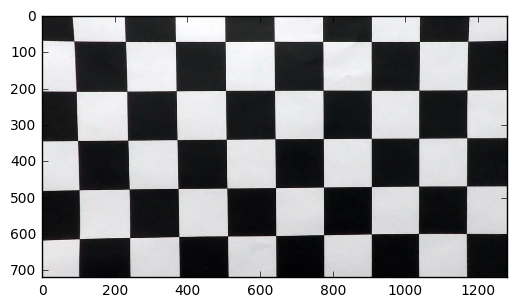

In [180]:
mtx, dist = load_calibration()
test_image = cv2.imread('camera_cal/calibration1.jpg')
undist = cv2.undistort(test_image, mtx, dist)
plt.imshow(undist)
plt.show()

In [191]:
img_size = (1280, 720)
src = np.float32([[  585.0-10,  460.0],
           [ 0.0,  720.0],
           [ 1280.0,  720.0],
           [ 695.0+10,  460.0]])

dst = np.float32([[320, 0], 
                  [320, 720],
                  [960, 720], 
                    [960, 0]])
        
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

def fast_unwarp_lane(img):
    undist = cv2.undistort(img, mtx, dist)
    out = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    return out

def fast_warp_lane(img, lane):
    unwarped = cv2.warpPerspective(lane, Minv, img_size, flags=cv2.INTER_LINEAR)
    out = cv2.addWeighted(img, 1, unwarped, 0.4, 0)
    return out

def process_video(infile, outfile, method):
    clip1 = VideoFileClip(infile)
    white_clip = clip1.fl_image(method) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(outfile, audio=False)

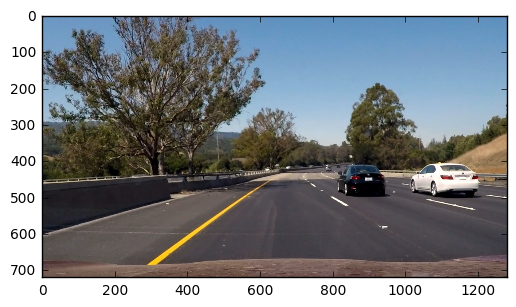

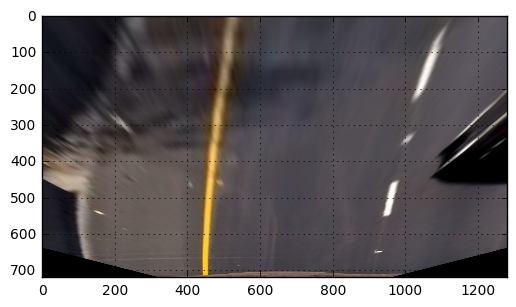

In [182]:
img = mpimg.imread('test_images/test6.jpg')
out = fast_unwarp_lane(img)

plt.imshow(img)
plt.show()

plt.imshow(out)
plt.grid(True)
plt.show()

# Unwarped Video

lets check how the complete video will look like and make sure all turns are covered in the frame.

In [309]:
inp = "project_video"
#inp = "challenge_video"

process_video(infile=inp + ".mp4", 
              outfile=inp + "_px.mp4", 
              method=fast_unwarp_lane)

[MoviePy] >>>> Building video project_video_px.mp4
[MoviePy] Writing video project_video_px.mp4


100%|█████████▉| 1260/1261 [01:13<00:00, 17.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_px.mp4 

CPU times: user 8min 7s, sys: 3.88 s, total: 8min 11s
Wall time: 1min 13s


# Masking Lanes

lets first conserve the yellow and white lanes as much as possible and filter all unwanted parts of the image.

`mask_image` method does this job. 

In [230]:

def plot_images(images):
    """ Helper routine which plots all images passed as array in a single row """
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(10*n, 10))
    for ix, img in enumerate(images):
        axes[ix].imshow(img, cmap='gray')
        axes[ix].axis('off')
    plt.show()


def abs_sobel_thresh(img_gray, orient='x', ksize=3,  thresh=(20,100)):    
    sobel = None
    if orient=='x':
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=ksize)
    else:
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=ksize)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255*abs_sobel/np.max(abs_sobel))

    binary_output = np.zeros_like(scaled)
    binary_output[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    
    return binary_output    
    
def mag_thresh(gray, ksize=9, thresh=(20,80)):    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    abssolxy = np.sqrt(sobelx ** 2 + sobely ** 2)    
    scaledxy = (abssolxy*255/np.max(abssolxy)).astype(np.uint8)
    binary_output = np.zeros_like(scaledxy)
    binary_output[(scaledxy >= thresh[0]) & (scaledxy <= thresh[1])] = 1
    return binary_output
    
def dir_thresh(gray, ksize=15, thresh=(0.0, np.pi/2)):    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    abssobelx = np.absolute(sobelx)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    abssobely = np.absolute(sobely)
    
    abssobelxy = np.arctan2(abssobely,abssobelx)

    binary_output = np.zeros(abssobelxy.shape, dtype=np.uint8)
    binary_output[(abssobelxy >= thresh[0]) & (abssobelxy <= thresh[1])] = 1
    return binary_output

def hls_select(image_hsv):
    i_h = image_hsv[:,:,0]
    i_s = image_hsv[:,:,1]
    i_v = image_hsv[:,:,2]
    
    res = np.zeros_like(i_h).astype(np.uint8)
    res[((i_h > 0) & (i_h < 80)) & (i_s > 0.313) & (i_v > 0.39)]  = 1 #yellow only
    res[(i_s < 0.156) & (i_v > 0.7)]  = 1 #white only
    
    return res

def apply_stage_1(img_gray):
    x_image = abs_sobel_thresh(img_gray, orient='x', ksize=3, thresh=(20,100))
    y_image = abs_sobel_thresh(img_gray, orient='y', ksize=3, thresh=(20,100))
    xy_image = mag_thresh(img_gray, ksize=9, thresh=(20,100))
    dir_image = dir_thresh(img_gray, ksize=9, thresh=(0.7, 1.3))

    img_stage_1 = np.zeros_like(x_image)
    img_stage_1[(x_image == 1) | ((xy_image == 1) & (dir_image == 1))]  = 1
    #img_stage_1[((x_image == 1) & (y_image == 1))]  = 1
    return img_stage_1


def apply_thresholds(img):
    img = cv2.undistort(img, mtx, dist, None, mtx)

    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    stage_1 = apply_stage_1(img_gray)
    stage_2 = hls_select(img_hsv)
    
    return stage_1, stage_2
    """
    mask = cv2.bitwise_or(yellow_mask, white_mask)
    masked_image = cv2.bitwise_and(image,image, mask=mask)
    return mask, masked_image
    #return white_mask, cv2.bitwise_and(image,image, mask=white_mask) to investigate only on
    """


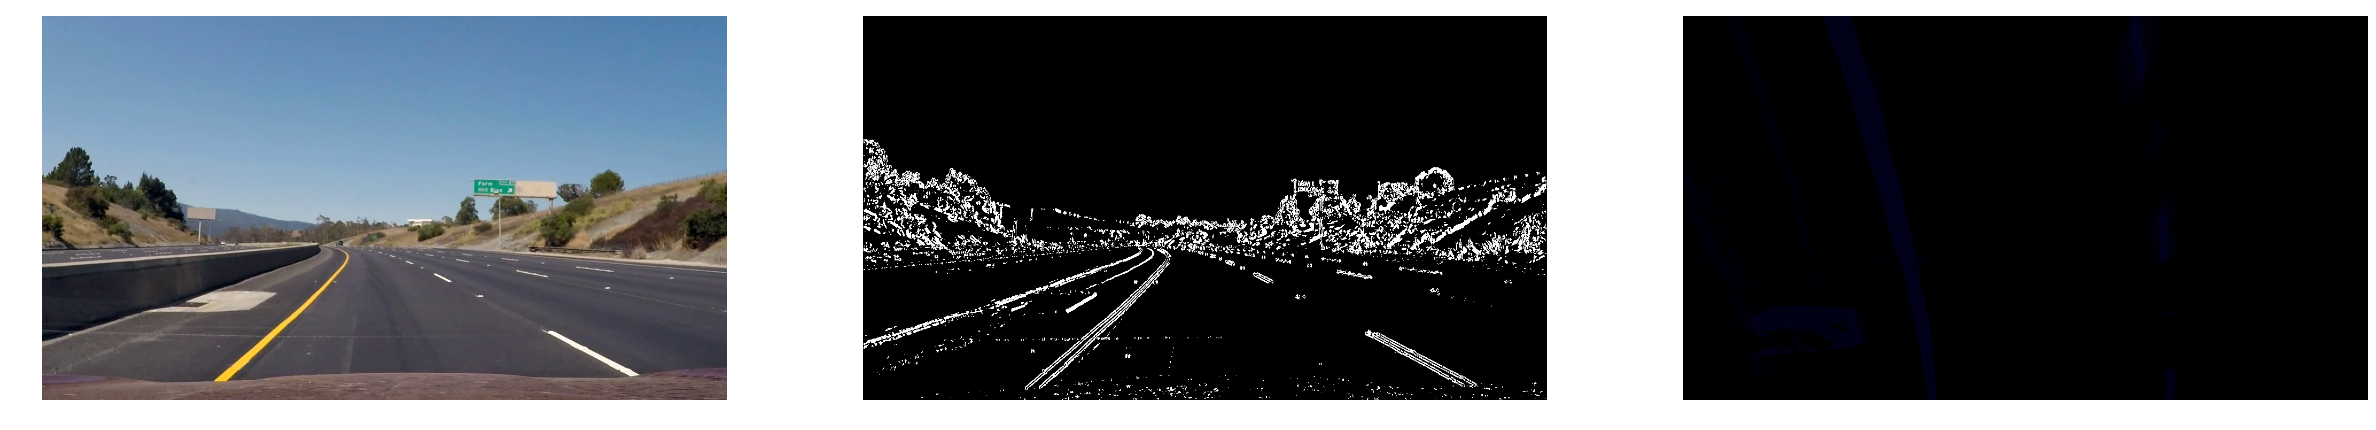

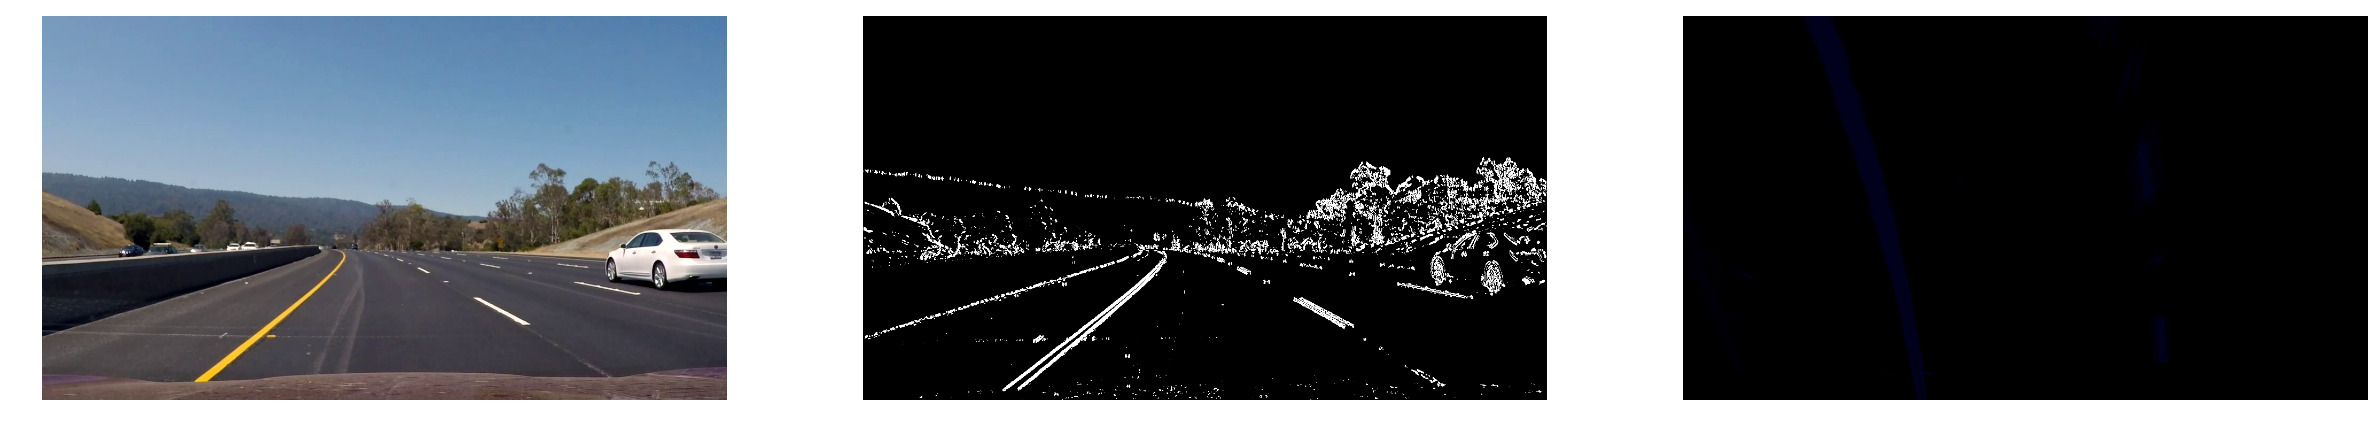

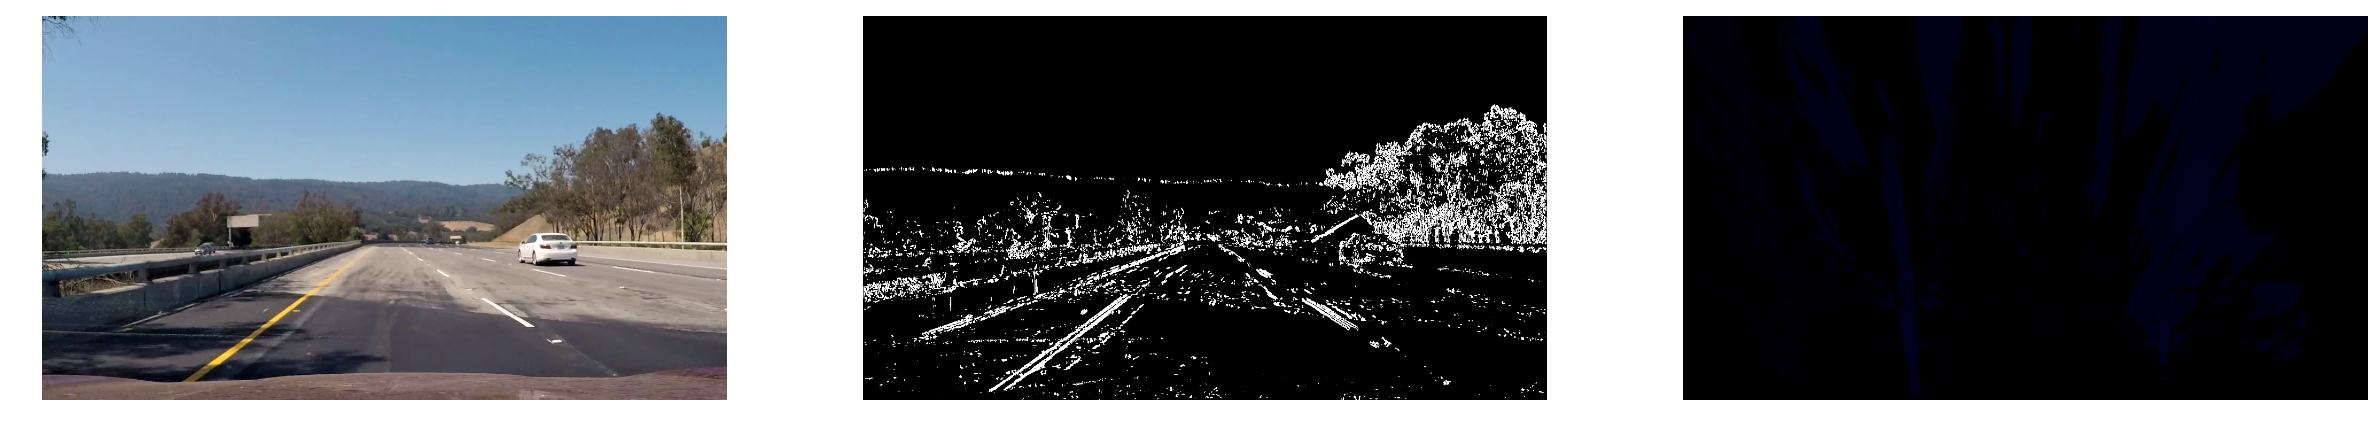

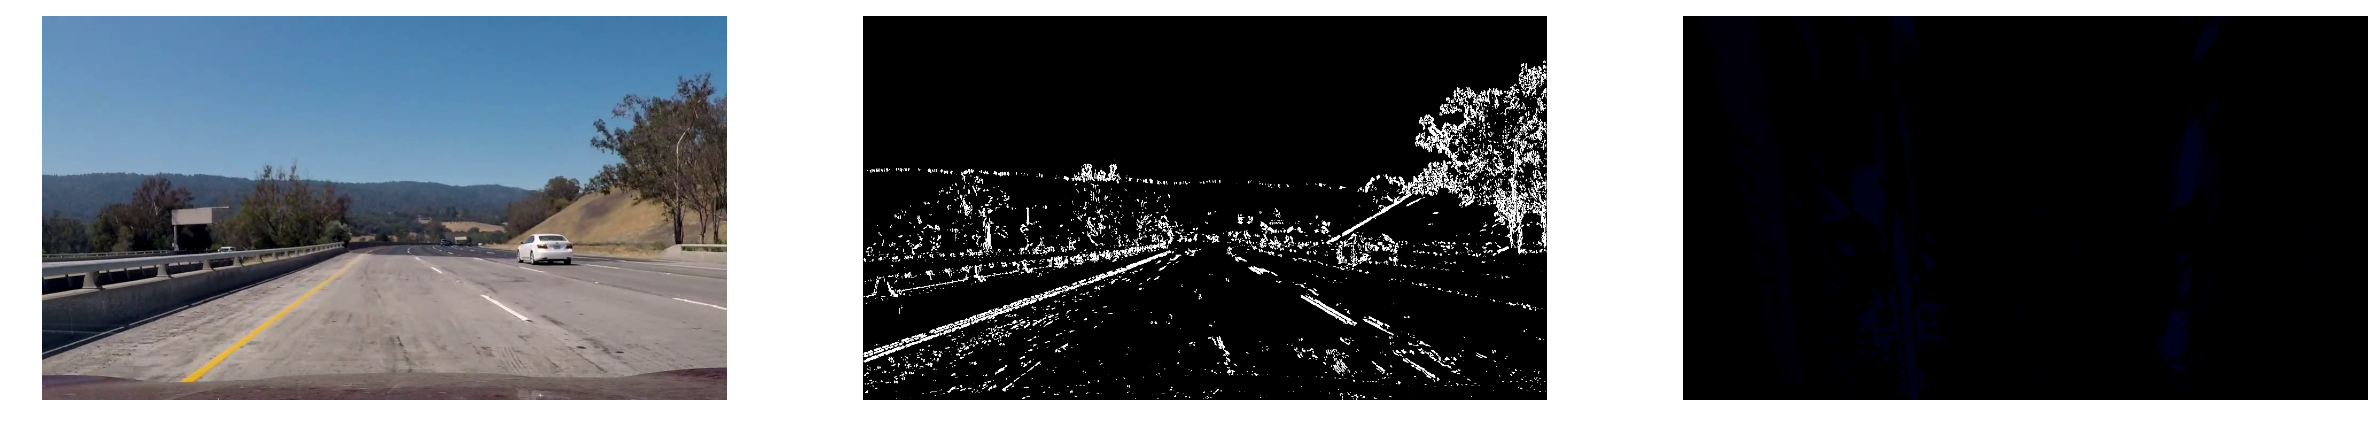

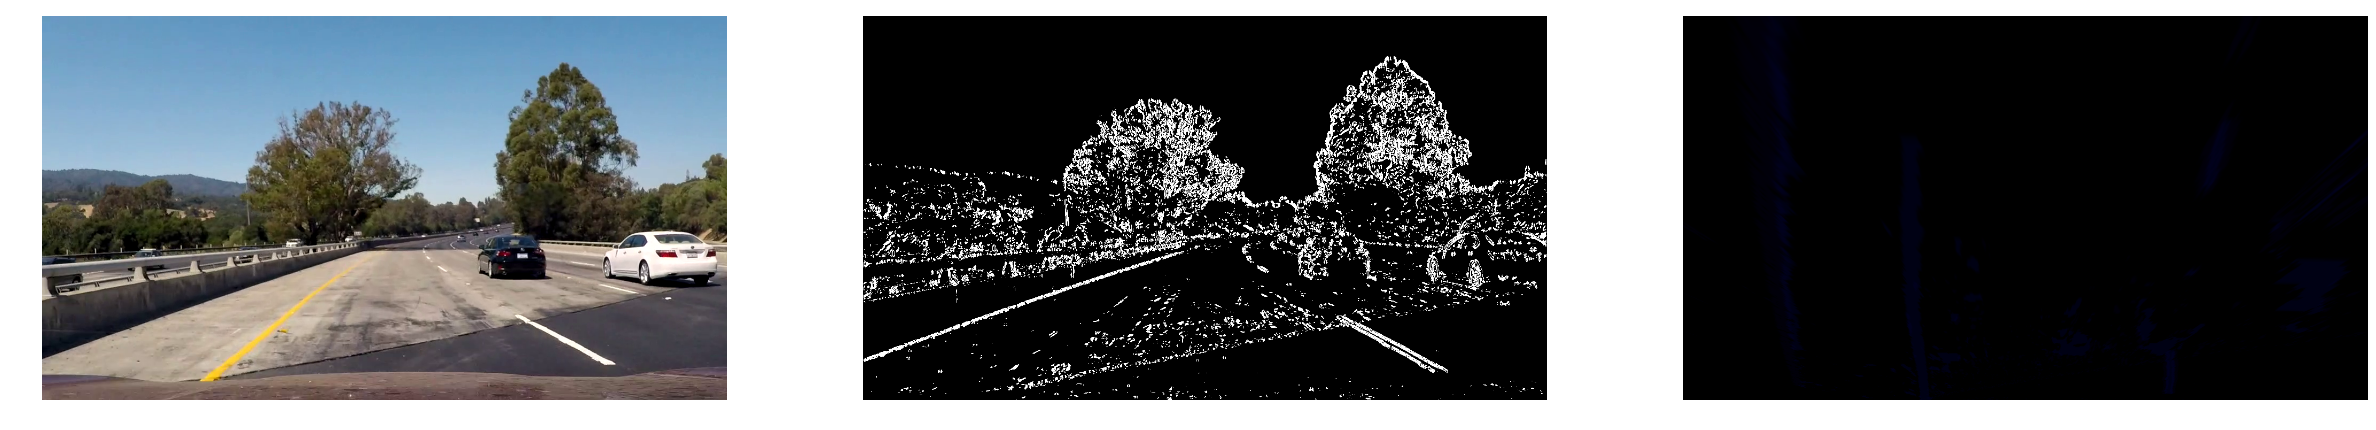

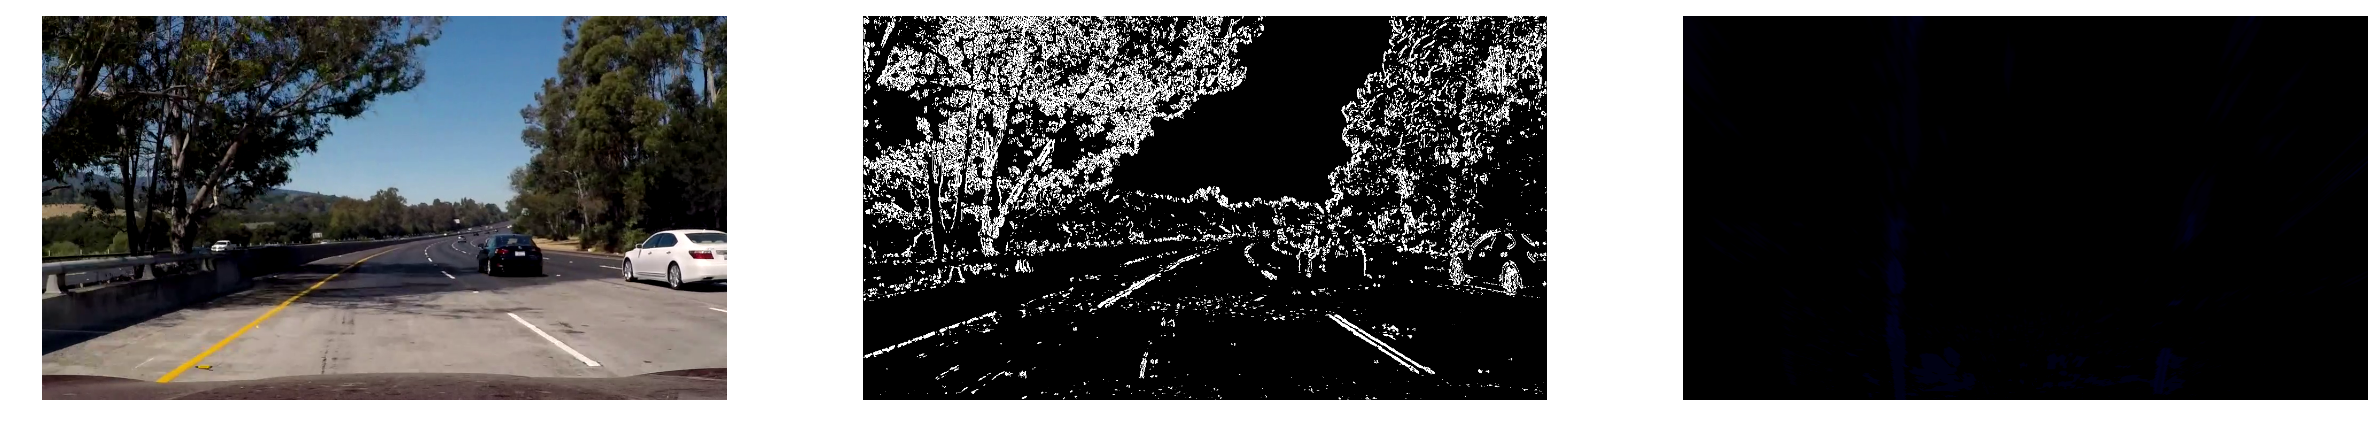

In [244]:
imagenames = glob.glob('snapshots/*.png')

lane_images = []

for ix, fname in enumerate(imagenames):
    img = mpimg.imread(fname)

    res1, res2 = apply_thresholds(img)
    res = None
    
    res_rgb = np.dstack((res1, res2, (res1*10)+(res2*20)))
    out = fast_unwarp_lane(res_rgb)

    plot_images([img, res1, out])
    lane_images.append(out)
    

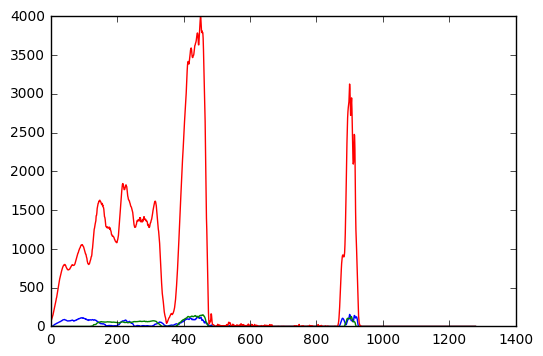

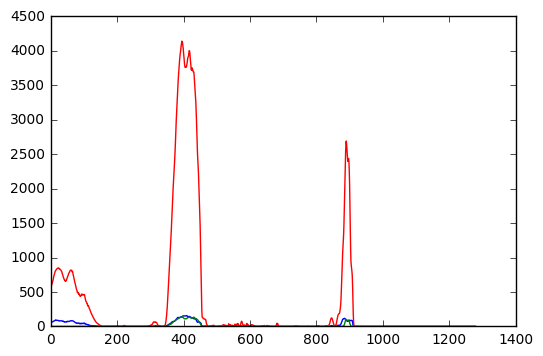

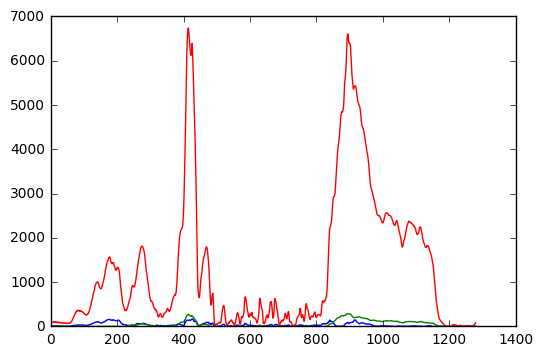

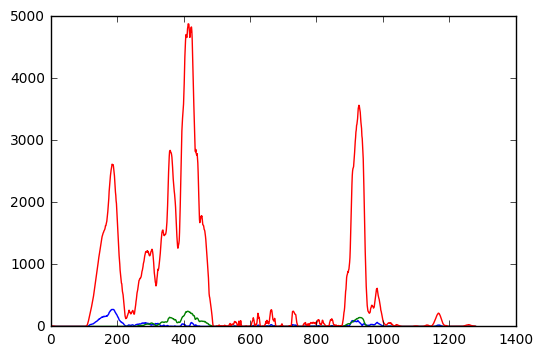

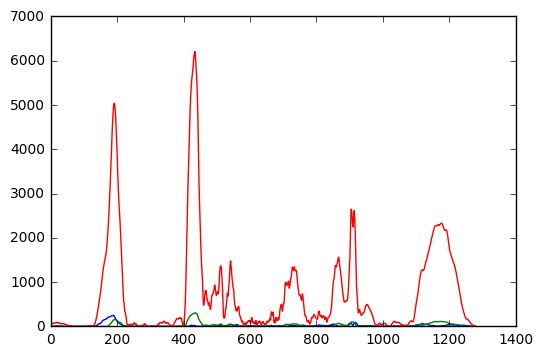

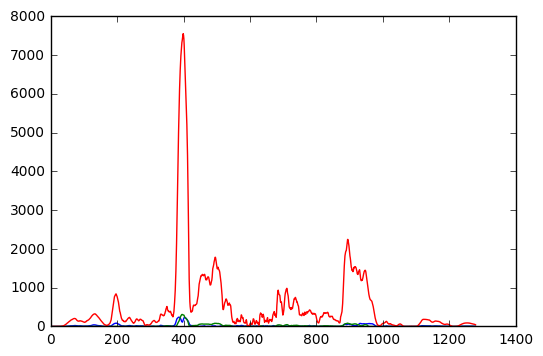

In [245]:
for lane in lane_images:
    histogram = np.sum(lane[lane.shape[0]/2:, :], axis=0)
    plt.plot(histogram)
    plt.show()

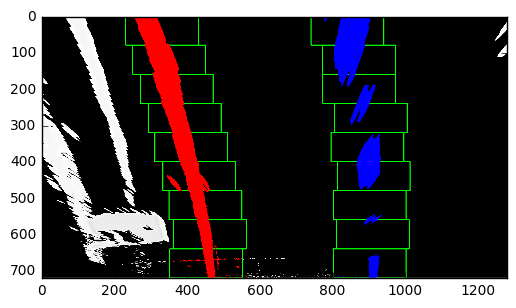

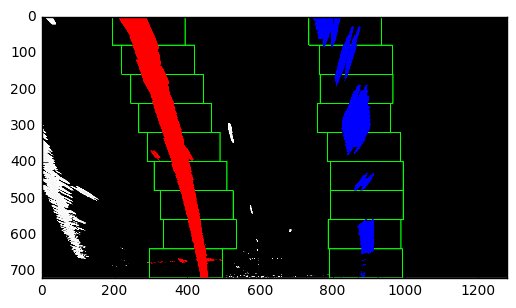

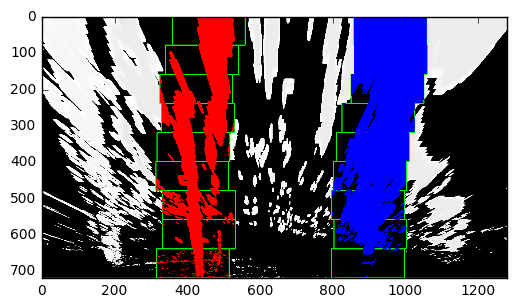

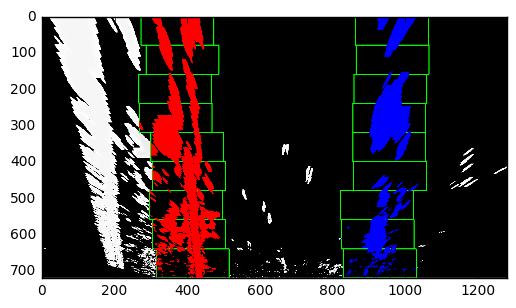

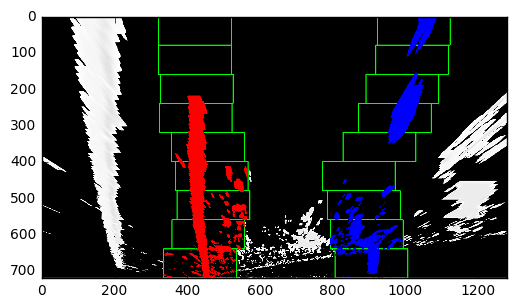

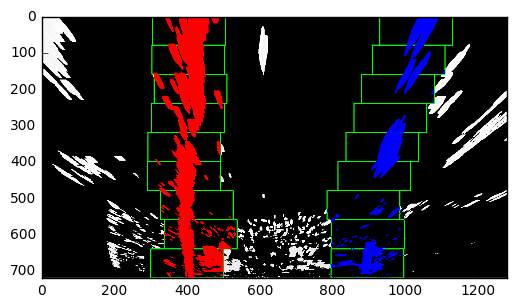

In [255]:
def heart_beat(lane):
    binary_warped = lane[:,:,2]

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img

    """

    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()

    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    """

for lane in lane_images:
    processed = heart_beat(lane)
    plt.imshow(processed)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()

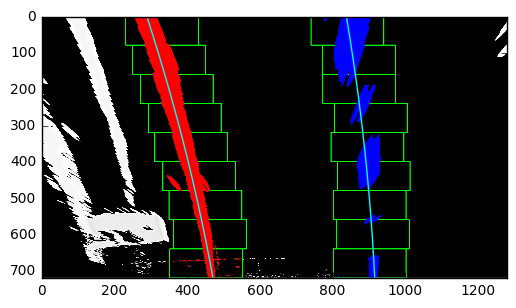

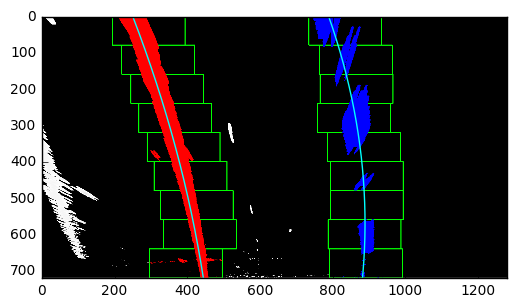

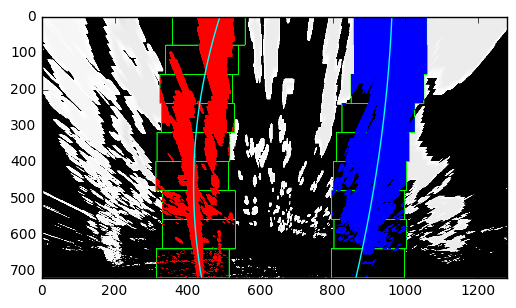

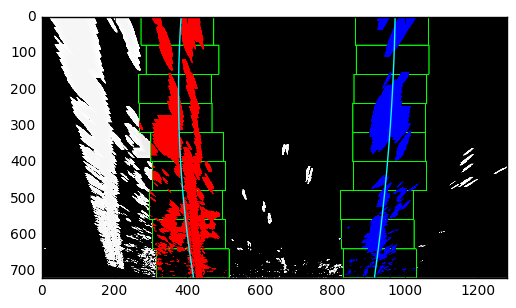

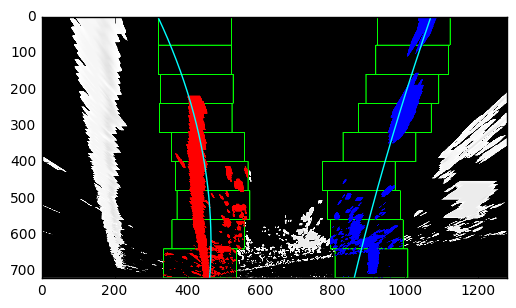

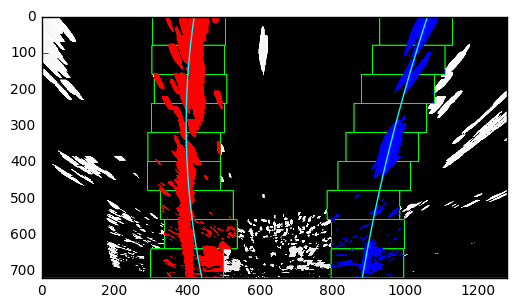

In [252]:
def find_lane_pixels(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img, left_fitx, right_fitx


for ix, lane in enumerate(lane_images):
    binary_warped = lane[:,:,2]

    out_img, left_fitx, right_fitx = find_lane_pixels(binary_warped)

    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='cyan')
    plt.plot(right_fitx, ploty, color='cyan')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()



In [258]:
#inp = "project_video"
inp = "challenge_video"

def lane_boxes(img):
    res1, res2 = apply_thresholds(img)
    res = res1 * 100 + res2*100
    
    res_rgb = np.dstack((res, res, np.zeros_like(res)))
    uw = fast_unwarp_lane(res_rgb)
    px = heart_beat(uw)
    return px

process_video(infile=inp + ".mp4", 
              outfile=inp + "_px_2.mp4", 
              method=lane_boxes)

TypeError: expected non-empty vector for x

In [259]:
#inp = "project_video"
inp = "challenge_video"

def lane_boxes(img):
    res1, res2 = apply_thresholds(img)
    res = (res1 * 10) + (res2*20)
    
    res_rgb = np.dstack((res, res, np.zeros_like(res)))
    uw = fast_unwarp_lane(res_rgb)
    px = heart_beat(uw)
    out = fast_warp_lane(img, px)
    return out

process_video(infile=inp + ".mp4", 
              outfile=inp + "_px_3.mp4", 
              method=lane_boxes)

TypeError: expected non-empty vector for x